In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
cali = fetch_california_housing()
df = pd.DataFrame(cali.data, columns=cali.feature_names)
df['target'] = cali.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


In [3]:
scaler = StandardScaler()
scaler.fit(df.values[:, :-1])
df.values[:, :-1] = scaler.transform(df.values[:, :-1])

df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
20635,-1.216128,-0.289187,-0.155023,0.077354,-0.512592,-0.049110,1.801647,-0.758826,0.781
20636,-0.691593,-0.845393,0.276881,0.462365,-0.944405,0.005021,1.806329,-0.818722,0.771
20637,-1.142593,-0.924851,-0.090318,0.049414,-0.369537,-0.071735,1.778237,-0.823713,0.923
20638,-1.054583,-0.845393,-0.040211,0.158778,-0.604429,-0.091225,1.778237,-0.873626,0.847
20639,-0.780129,-1.004309,-0.070443,0.138403,-0.033977,-0.043682,1.750146,-0.833696,0.894


In [4]:
data = torch.from_numpy(df.values)
data = data.float()
data.dtype

torch.float32

In [5]:
x = data[:,:-1]
y = data[:, -1:]

In [6]:
x.shape, y.shape

(torch.Size([20640, 8]), torch.Size([20640, 1]))

In [7]:
epochs = 1000
batch = 256
interval = 100
lr = 1e-2

In [8]:
model = nn.Sequential(
    nn.Linear(x.size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 2),
    nn.LeakyReLU(),
    nn.Linear(2, y.size(-1)))

model

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=4, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=4, out_features=2, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=2, out_features=1, bias=True)
)

In [10]:
optimizer = optim.Adam(model.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [11]:
for i in range(epochs):
    indices = torch.randperm(x.size(0))
    x_ = torch.index_select(x, dim=0, index = indices)
    y_ = torch.index_select(y, dim=0, index = indices)
    
    x_ = x_.split(batch, dim=0)
    y_ = y_.split(batch, dim=0)
    
    y_hat = []
    total_loss = 0
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        total_loss += float(loss)
        
        y_hat += [y_hat_i]
    
    total_loss = total_loss / len(x_)
    
    if (i+1) % interval == 0:
        print('Epoch %d: loss=%.4e' % (i+1, total_loss))
y_hat = torch.cat(y_hat, dim=0)
y = torch.cat(y_, dim=0)

Epoch 100: loss=3.9335e-01
Epoch 200: loss=3.8325e-01
Epoch 300: loss=3.8019e-01
Epoch 400: loss=3.7890e-01
Epoch 500: loss=3.7817e-01
Epoch 600: loss=3.7710e-01
Epoch 700: loss=3.7737e-01
Epoch 800: loss=3.6318e-01
Epoch 900: loss=3.5433e-01
Epoch 1000: loss=3.5187e-01


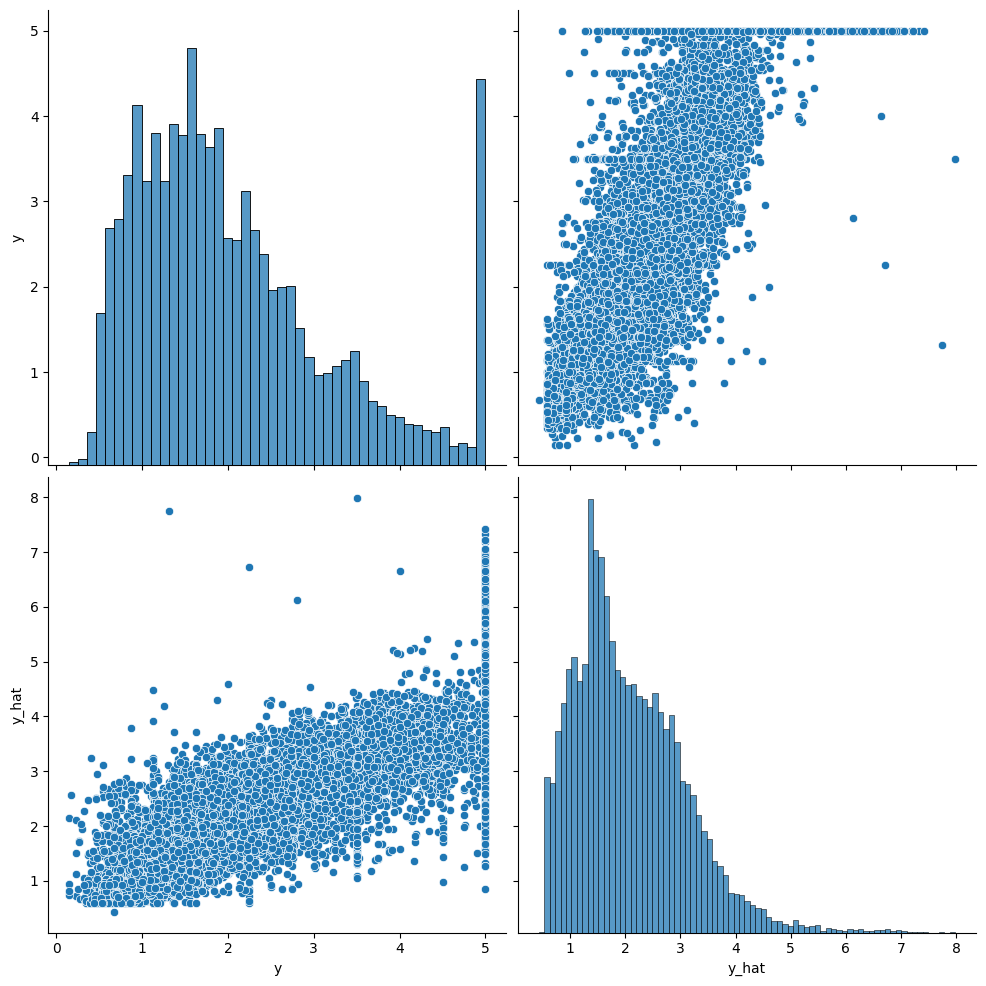

In [12]:
df = pd.DataFrame(torch.cat([y, y_hat], dim=1).detach().numpy(), columns=['y', 'y_hat'])
sns.pairplot(df, height=5)
plt.show()